# Cloud radar data collected at the Barbados Cloud Observatory (BCO)

```{figure} figures/coral_radar.jpg
:alt: BCO
:width: 400px
:align: center
```

## General information

The polarised 35.5 GHz Doppler radar is part of the Combined Radar And Lidar instrument (CORAL) at the Barbados Cloud Observatory (BCO). It has a sensitivity of -48 dBZ at an altitude of 5 km and -70 dBZ at an altitude of 500 m. The radar has a range gating of 31.18 m and measures at ranges between 150 m and 18.9 km. It operates in a zenith looking mode, so that range gating effectively measures distance in the vertical. To measure the vertical velocity the radar uses the Doppler technique with an FFT of 256 samples, giving it a Doppler resolution of < 0.02 ms$^{-1}$ between -10 and 10 ms$^{-1}$. The radar is able to provide the linear depolarisation ratio (LDR), which can be used for a target classification based on their shape. Data processing and radar calibration are done by following {cite:t}`Gorsdorf:2015`, which leads to an uncertainty of 1.3 dB.

## Radar characteristics

| Characteristic              | CORAL Ka-band radar                 |
| --------------------------- | ------------------------------------|
| Radar type                  |  Mono static, pulsed, magnetron     |
| Frequency                   |  35.5 GHz $\pm$ 150 MHz             |
| Peak power                  |  30 kW                              |
| Pulse width                 |  200 ns for 30 m range resolution   |
| Doppler velocity resolution |  0.02 ms$^{-1}$                     |
| Diameter of antenna         |  2 m                                |
| Antenna beam width          |  0.3 deg x 0.3 deg                  |
| Sensitivity                 |  -48 dBZ at 5 km, -70 dBZ at 500 m  |

### Getting the data catalog

The python code below allows you to analyze the available measurements within January/February 2020.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
plt.style.use(["./mplstyle/book", "./mplstyle/wide"])
import numpy as np
import eurec4a
cat = eurec4a.get_intake_catalog()

### Getting the data from the BCO Ka-band radar
To get a list of BCO datasets that are available within the catalog, type:

In [2]:
list(cat['barbados.bco'])

['CORAL_LIDAR', 'radar_reflectivity']

### Loading the radar dataset
The entire radar dataset of the BCO Ka-band radar can be loaded lazy, i.e. only loading the metadata and not the data such like radar reflectivity itself, by typing:

In [3]:
ds = cat.barbados.bco.radar_reflectivity.to_dask()

The variables that this dataset contains can be shown by typing:

In [4]:
ds

<xarray.Dataset>
Dimensions:     (range: 605, time: 2037350)
Coordinates:
  * range       (range) float64 155.9 187.1 218.2 ... 1.896e+04 1.899e+04
  * time        (time) datetime64[ns] 2020-01-12T16:19:26 ... 2020-02-29T23:5...
Data variables: (12/23)
    tpow        (time) float32 ...
    zenith      (time) float32 ...
    northangle  (time) float32 ...
    MeltHei     (time) float32 ...
    RadarConst  (time) float32 ...
    latitude    (time) float64 ...
    ...          ...
    HSDco       (time, range) float32 ...
    HSDcx       (time, range) float32 ...
    Ze          (time, range) float32 ...
    Zg          (time, range) float32 ...
    Zf          (time, range) float32 ...
    mask        (time, range) bool ...
Attributes: (12/17)
    location:        The Barbados Cloud Observatory, Deebles Point, Barbados,...
    Altitude:        11 m
    system:          MIRA36
    title:           MIRA-3x Cloud Radar Data
    institution:     Max Planck Institute for Meteorology, Hamburg
    source:          /pool/OBS/BARBADOS_CLOUD_OBSERVATORY/Level_1/B_Reflectiv...
    ...              ...
    python_version:  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) ...
    Conventions:     CF-1.7
    DOI:             10.25326/55
    contact_person:  Lutz Hirsch (lutz.hirsch@mpimet.mpg.de)
    history:         Concatenated dataset of daily converted source files
    _NCProperties:   version=2,netcdf=4.6.2,hdf5=1.10.4

### Plot some radar quantities
To create time/height plots for radar moments, pick a variable name having dimension `(time, height)` from the list of data variables and type the name in the code below. Common quantities that are used from the radar are radar reflectivity and doppler velocity. The radar reflectivity that is corrected for "rabbit ears" is saved in `Zf`.

In the following an example timeseries for both of these quantities is shown:
to select the entire day :

In [5]:
time_min = np.datetime64('2020-02-12T00:00:00')
time_max = np.datetime64('2020-02-12T23:59:59')

# selecting subset of data
ds_sliced = ds.sel(time=slice(time_min, time_max))

Text(0, 0.5, 'range / m')

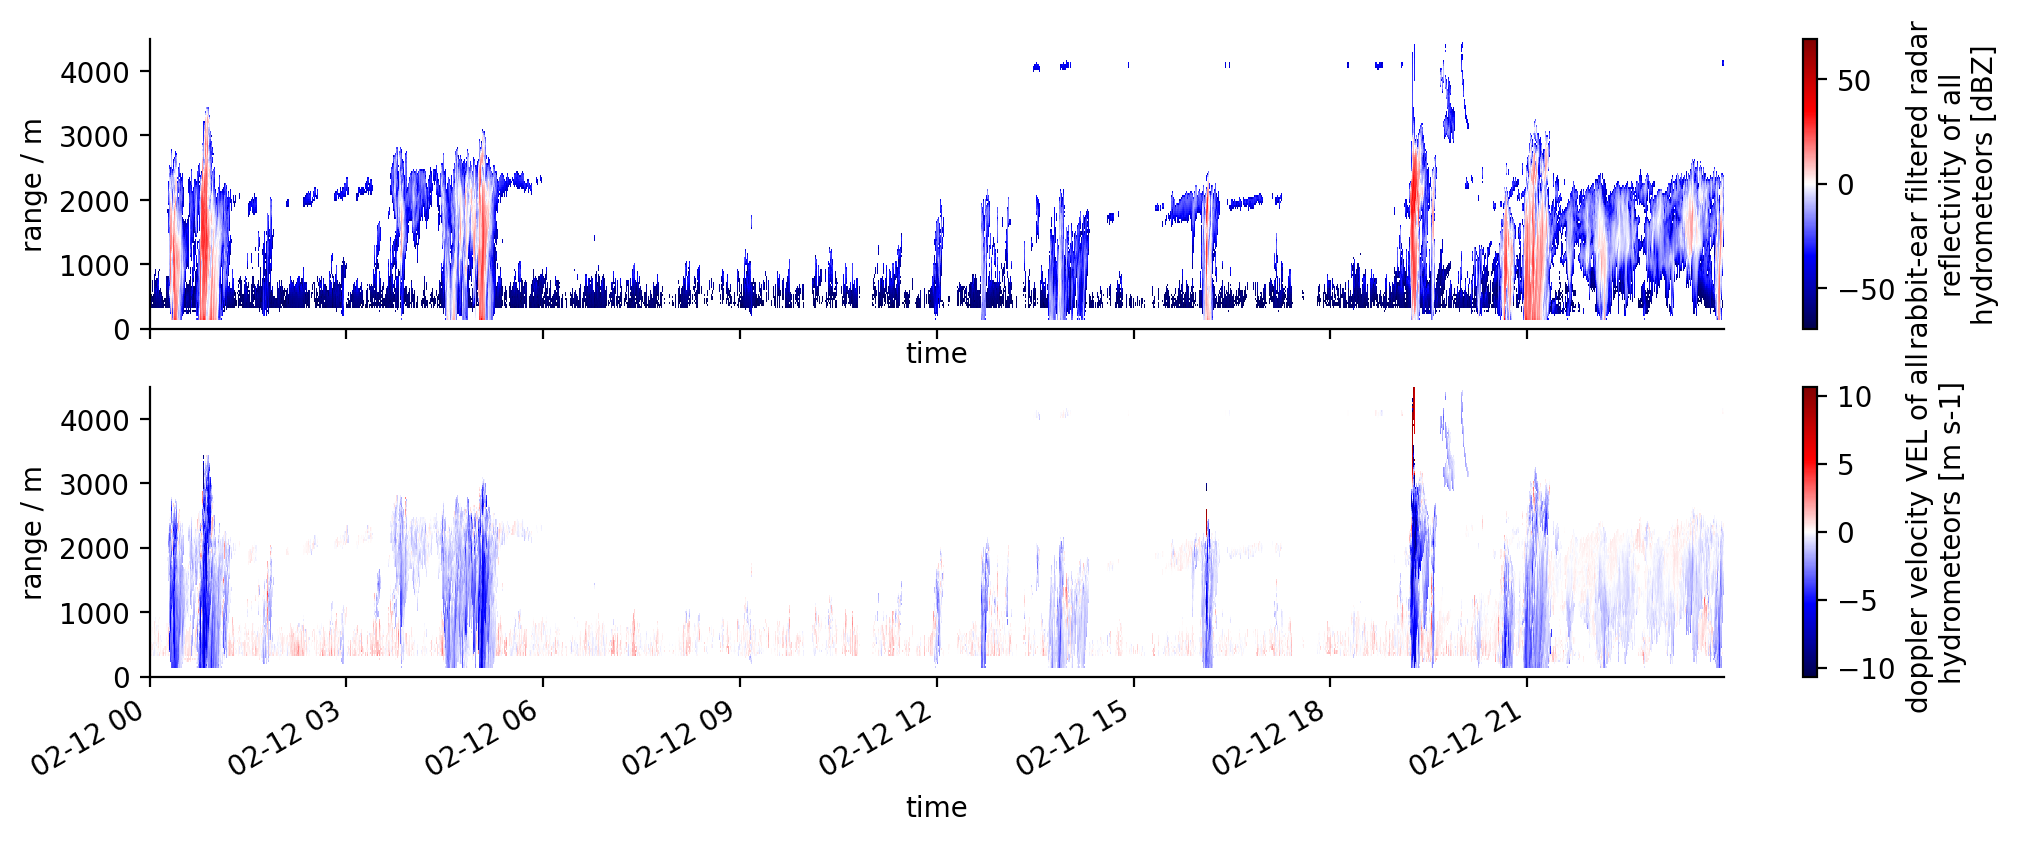

In [6]:
fig, axs = plt.subplots(2,1, sharex=True)
# set here the variable from ds to plot, its color map and its min and max values
ds_sliced.Zf.plot(x='time', y='range', cmap="seismic", ax=axs[0])
ds_sliced.VEL.plot(x='time', y='range', cmap="seismic", ax=axs[1])
axs[1].set_xlim(time_min, time_max)
axs[0].set_ylim(0, 4500);
axs[1].set_ylim(0, 4500);
axs[0].set_ylabel('range / m')
axs[1].set_ylabel('range / m')

### Retrieving cloud fraction profile
The cloud fraction profile provides information about the variability of cloudiness at different height levels. The radar is often used to retrieve such a profile, but it should be noted that cloud quantities are not easy to define (see also the section about the [HALO cloud mask product](cloudmasks.md)) and the cloud fraction profile can look very different depending on the instrument and its sensitivity. The Ka-Band radar at the BCO captures for example not only cloud and rain droplets, but also moistened sea-salt aerosols. The example below illustrates how the profiles depend on the chosen reflectivity threshold. Note, to be precise the following examples shows the echo fraction and not the cloud fraction.

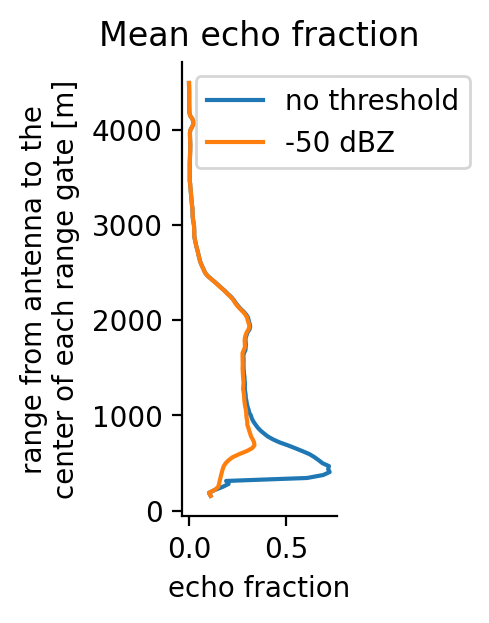

In [7]:
fig, ax = plt.subplots(figsize=(2,3))
# calculate the mean cloud fraction profile
(~np.isnan(ds_sliced.Zf.sel(range=slice(0,4500)))).mean(dim='time').plot(y='range', label='no threshold')
# reduce sensitivity
threshold = -50
(ds_sliced.Zf > threshold).sel(range=slice(0,4500)).mean(dim='time').plot(y='range', label=f'{threshold} dBZ')
plt.title("Mean echo fraction")
plt.xlabel('echo fraction')
plt.legend();

The threshold of -50 dBZ is chosen following {cite:t}`Klingebiel:2019` to exclude reflectivities from moistened sea-salt aerosols.
For questions regarding the instrument, please contact the contact person given in the metadata of this dataset.